In [1]:
import mne
import pandas as pd

# Cargar los datos de EEG usando MNE
raw = mne.io.read_raw_edf('SN001.edf', preload=True)
sf = raw.info['sfreq']
data = raw.get_data() * 1e6  # Convertir a microvoltios (uV)



Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/testing_silly_things/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


In [2]:
def read_scoring_file(file_path):
    df = pd.read_csv(file_path, sep=',')
    df['Annotation'] = df['Annotation'].str.rstrip(',')
    return df

def correct_stage(stage):
    # Mapeo de cada etapa de sueño a un valor numérico
    stages_map = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
    return stages_map.get(stage, 'problem')

def get_scoring(df):
    # Extraer las etapas de sueño de la columna 'Annotation'
    # Filtra los valores que comienzan con "Sleep stage"
    df_filtered = df[df['Annotation'].str.contains("Sleep stage", na=False)]
    # Obtener la última palabra (etapa de sueño) de cada anotación
    stages = df_filtered['Annotation'].apply(lambda x: x.split()[-1])
    # Convertir las etapas de sueño a formato numérico
    return [correct_stage(stage) for stage in stages]



In [3]:
from mne.filter import filter_data

# Filtrar en la banda sigma (11-16 Hz)
data_sigma = filter_data(data[0], sfreq=sf, l_freq=11, h_freq=16)


import yasa

# Detección de espigas en el canal de EEG
spindles = yasa.spindles_detect(data_sigma, sf=sf)

# Verifica si la detección fue exitosa
if spindles is not None:
    spindles_summary = spindles.summary()  # Resumen de espigas detectadas
    print(spindles_summary)
else:
    print("No se detectaron espigas en los datos.")




Setting up band-pass filter from 11 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 11.00
- Lower transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 9.62 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 309 samples (1.207 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


             Start          Peak           End  Duration  Amplitude       RMS  \
0        49.820312     50.824219     51.097656  1.277344  21.138359  4.440620   
1        89.781250     90.488281     90.890625  1.109375  27.561093  6.285857   
2       119.562500    119.761719    120.152344  0.589844  21.931652  5.062351   
3       180.156250    180.238281    181.695312  1.539062  17.616376  4.017317   
4       184.062500    184.976562    185.140625  1.078125  19.778566  4.614169   
...            ...           ...           ...       ...        ...       ...   
2863  25613.109375  25614.214844  25614.621094  1.511719  24.510920  5.230956   
2864  25624.761719  25625.050781  25626.085938  1.324219  22.966964  4.003037   
2865  25636.613281  25636.851562  25637.476562  0.863281  22.491198  4.267865   
2866  25638.921875  25639.148438  25640.273438  1.351562  58.230185  7.733033   
2867  25647.222656  25647.847656  25648.015625  0.792969  18.871970  4.623695   

      AbsPower  RelPower  F

In [4]:
import pandas as pd

# Cargar el archivo usando coma como delimitador
file_path = 'SN001_sleepscoring.txt'
df = pd.read_csv(file_path, sep=',\s*', engine='python')  # '\s*' permite espacios alrededor de las comas

# Verificar si las columnas se leen correctamente
print(df.head())
print(df.columns)


       Date          Time  Recording onset  Duration     Annotation  \
0  01.01.01      23.59.30             0.00        30  Sleep stage W   
1  02.01.01      00.00.00            30.00        30  Sleep stage W   
2  02.01.01  00.00.03.430            33.43         0     Lights off   
3  02.01.01      00.00.30            60.00        30  Sleep stage W   
4  02.01.01      00.01.00            90.00        30  Sleep stage W   

  Linked channel  
0            NaN  
1            NaN  
2      EEG F4-A1  
3            NaN  
4            NaN  
Index(['Date', 'Time', 'Recording onset', 'Duration', 'Annotation',
       'Linked channel'],
      dtype='object')


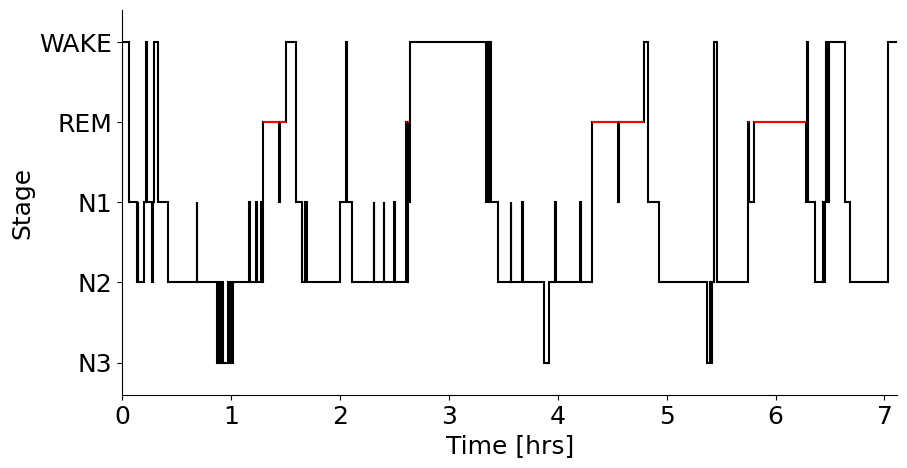

In [5]:
import matplotlib.pyplot as plt
import yasa

# Obtener las etapas de sueño del DataFrame
stages = get_scoring(df)

# Visualizar el hipnograma
plt.figure(figsize=(10, 5))
yasa.plot_hypnogram(stages)
plt.show()
